## Training model on discrete 1D data

In [24]:
import torch

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Generating of 1D Data 

### Вопрос 1

Как зная математическое ожидание $\mu$ и стандартное отклонение $\sigma$ распределения , получать семплы из него $\mathcal{N}(\mu,\sigma^{2})$?

In [62]:
mu = 0.1*torch.ones(1)
std = 2*torch.ones(1)
x = mu + std*torch.randn(100)

In [64]:
x

tensor([ 1.5487, -2.1133,  1.6143,  0.4453,  0.1344,  2.3123,  2.7664, -0.4326,
        -1.8682, -0.9319, -1.4333,  0.7801,  1.6060,  4.5341, -1.5975, -0.0430,
        -2.3000,  0.6921,  3.1050, -2.2594, -1.6563, -0.6555,  3.9745, -5.2941,
        -0.6380,  1.5823, -1.8207,  1.5011,  1.4499, -3.2087,  2.0418, -1.5248,
        -1.6138, -4.3225,  0.5161,  3.6834,  1.3778, -2.2198,  1.8132, -2.1061,
         2.1571, -1.2595, -3.0131,  1.1720, -0.0144,  1.9751,  3.7404,  2.1737,
        -0.9230, -2.5240,  3.1794,  1.2982, -1.3567,  2.3212,  3.0335,  0.6802,
        -0.2462,  3.3293,  2.3303, -3.0991,  1.7637,  0.3436, -1.1426,  1.1958,
        -2.7983, -1.3413,  0.9054, -1.1921, -2.3196, -0.6170, -1.0994, -4.5979,
        -3.0311, -0.8888,  0.1292, -0.7151,  1.8252, -1.7209, -0.1593,  2.2709,
        -0.5903, -2.9041, -0.8307,  1.6341, -4.7289,  1.9450, -1.9765, -2.1813,
        -0.1856,  4.9264, -0.4215,  0.8921, -1.9401,  0.5773, -2.5428,  1.0039,
        -1.2352, -3.9116, -2.0758,  0.55

In [25]:
def generate_1d_data(count, bins):
    np.random.seed(42)

    a = 0.2 + 0.05 * np.random.randn(count)
    b = 0.6 + 0.15 * np.random.randn(count)

    mask = np.random.rand(count) < 0.5

    samples = (a * mask + b * (1 - mask)) * (bins - 1)
    
    data = np.clip(samples.astype('int'), 0.0, (bins - 1))
    
    split = int(0.8 * count)
    train_data, test_data = data[:split], data[split:]
    return train_data, test_data

In [26]:
def plot_1d_data(train_data, test_data):
    bins = int(max(test_data.max(), train_data.max()) - min(test_data.min(), train_data.min())) + 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.set_title('train')
    ax1.hist(train_data, bins=bins, density=True)
    ax1.set_xlabel('x')
    ax2.set_title('test')
    ax2.hist(test_data, bins=np.arange(bins), density=True)
    plt.show()

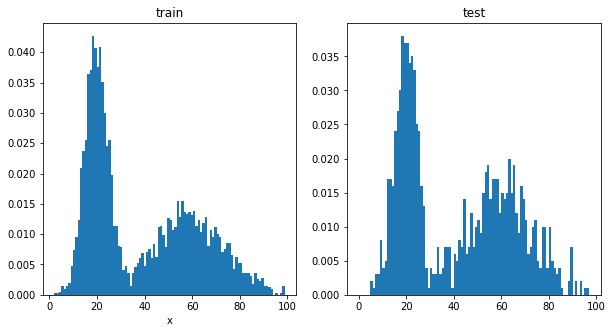

In [27]:
BINS = 100
COUNT = 5000

train_data, test_data = generate_1d_data(COUNT, BINS)
plot_1d_data(train_data, test_data)

### 2. Model for training

### Вопрос 2 

- Запрашивает ли градиент переменная проиницилизированная как torch.nn.Parameter(data) ?

- Что такое torch.unsqueeze? Отличается ли это от torch.view и если да то чем?

- Значения функции Softmax лежат между какими значениями?

In [44]:
class SoftmaxModel(torch.nn.Module):

    def __init__(self, bins):
        """
        logits - torch.tensor of shape [bins]

        """
        super().__init__()

        self.bins = bins
        self.logits = torch.nn.Parameter(torch.zeros(bins)) # torch.Size([bins])

    def forward(self, x):
        
        """
        x -  torch.tensor of shape [B,1]

        """
        
        logits = self.logits.unsqueeze(0).repeat(x.shape[0], 1) # torch.tensor [1,bins] -> [B,bins]
     
        return logits

In [29]:
def get_distribution(model):
    distribution = torch.nn.functional.softmax(model.logits, dim=0)
    return distribution.detach().cpu().numpy()

In [45]:
# check that your model outputs right shape
model = SoftmaxModel(BINS)
assert [10, BINS] == list(model(torch.rand((10,))).size())

Let $\theta = \{\theta_{0},...,\theta_{d}\}$ : Your model is softmax $ p(k|\theta) = \frac{e^{\theta_{k}}}{\sum_{l=1}^{d} e^{\theta_{l}}} $

### 3. Training of model

### Вопрос 3

- Как будет устроен лосс данной задачи ?
- В чем разница между model.train(False) и model.eval()?
- Что произойдет если на валидации не написать model.eval()?

In [ ]:
[B] - [B/4] [B/4] [B/4] [B/4]
model.backward(retain_graph = False)

# cuda out of memory

In [56]:
def get_cross_entropy_loss(model, x):
    # we advice you firstly understand the 1st task
    # and then return to this code
    # your code
    return torch.nn.functional.cross_entropy(model(x), x.long())

In [57]:
def train_epoch(model, train_loader, optimizer, use_cuda):
    model.train()
  
    train_losses = []
    for x in train_loader:
        if use_cuda:
            x = x.cuda()
        loss = get_cross_entropy_loss(model, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    return train_losses

In [58]:
def eval_model(model, data_loader, use_cuda):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            if use_cuda:
                x = x.cuda()
            loss = get_cross_entropy_loss(model, x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()


def train_model(model, train_loader, test_loader, epochs, lr, use_cuda=False):
    if use_cuda:
        model = model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = [eval_model(model, test_loader, use_cuda)]
    for epoch in range(epochs):
        model.train()
        train_losses.extend(train_epoch(model, train_loader, optimizer, use_cuda))
        test_loss = eval_model(model, test_loader, use_cuda)
        test_losses.append(test_loss)

    return train_losses, test_losses

In [59]:
BATCH_SIZE = 128
EPOCHS = 100
LR = 0.01
USE_CUDA = False

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=EPOCHS, lr=LR, use_cuda=USE_CUDA)

# check that your loss is not too large
assert test_losses[-1] < 4.25

In [60]:
def plot_training_curves(train_losses, test_losses):
    plt.figure(figsize=(8, 6))
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label='train loss')
    plt.plot(x_test, test_losses, label='test loss')
    plt.legend()
    plt.title('training curves')
    plt.xlabel('Epoch')
    plt.ylabel('NLL')
    
    
def plot_1d_distribution(data, distribution):
    size = len(distribution)

    plt.figure(figsize=(8, 6))
    plt.hist(data, bins=np.arange(size) - 0.5, label='train data', density=True)

    x = np.linspace(-0.5, size - 0.5, 1000)
    y = distribution.repeat(1000 // size)
    plt.plot(x, y, label='learned distribution')

    plt.title('learned distribution')
    plt.xlabel('x')
    plt.ylabel('Probability')
    plt.legend()

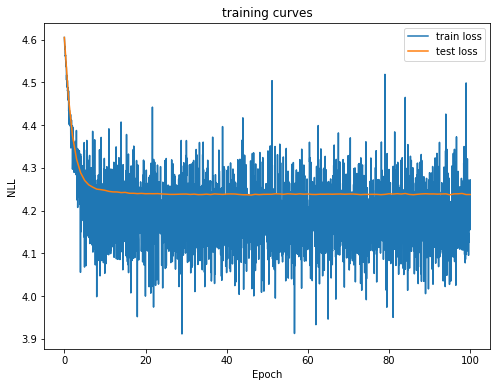

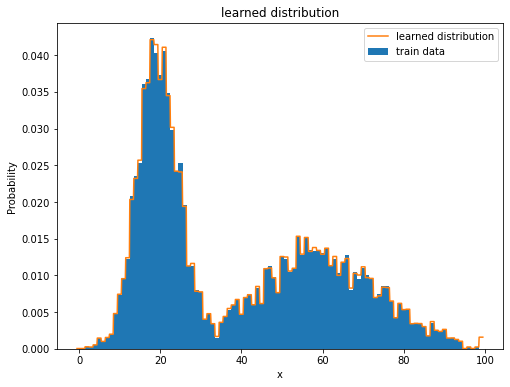

In [61]:
distribution = get_distribution(model)

assert isinstance(distribution, np.ndarray)
assert distribution.shape == (BINS,)

plot_training_curves(train_losses, test_losses)
plot_1d_distribution(train_data, distribution)